<a href="https://colab.research.google.com/github/20134571/20134571.github.io/blob/main/Ungrouped_Features_Baseline_ML1109_With_SMOTE_5CV_2409AJB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


===== Fold 1/5 =====

===== Fold 2/5 =====

===== Fold 3/5 =====

===== Fold 4/5 =====

===== Fold 5/5 =====


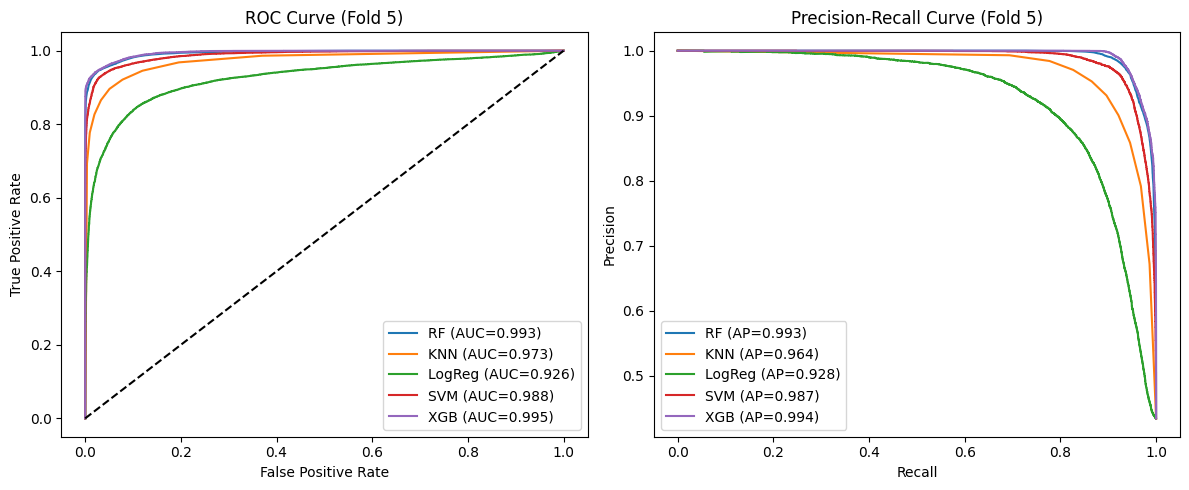

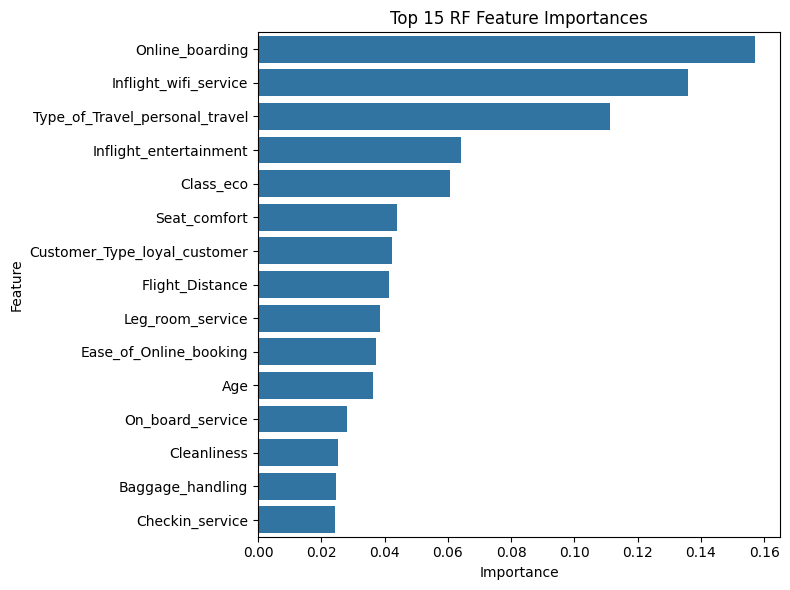

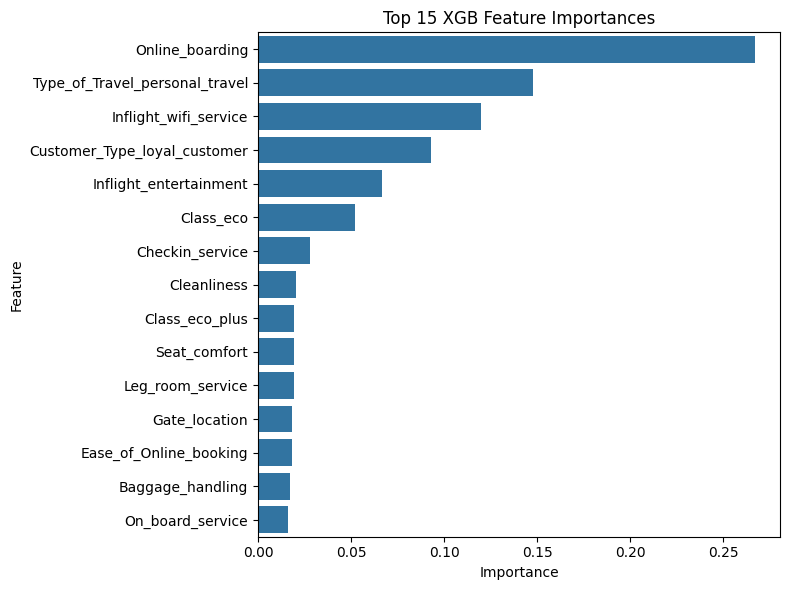


=== Average 5-Fold Results ===
        Accuracy  Prec_0  Rec_0   F1_0  Prec_1  Rec_1   F1_1  MacroF1  \
Model                                                                   
XGB        0.962   0.962  0.971  0.966   0.961  0.950  0.956    0.961   
RF         0.960   0.962  0.968  0.965   0.958  0.950  0.954    0.959   
SVM        0.946   0.952  0.953  0.953   0.939  0.938  0.938    0.945   
KNN        0.922   0.922  0.942  0.932   0.923  0.896  0.909    0.920   
LogReg     0.863   0.888  0.868  0.878   0.833  0.858  0.845    0.862   

        WeightedF1  
Model               
XGB          0.962  
RF           0.960  
SVM          0.946  
KNN          0.922  
LogReg       0.864  


In [4]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 11 08:05:47 2025
@author: heidi
"""

# ============================ STABILITY ============================
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

# ============================ Imports ============================
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception as e:
    HAS_XGB = False
    print("ℹ️ Skipping XGBoost (import failed):", e)

# ============================ Config ============================
N_JOBS_PAR = 2
PCA_VARIANCE = 0.95
N_SPLITS = 5

# ============================ Load Data ============================
url = "https://raw.githubusercontent.com/20134571/AISKILLSET/main/airline_satisfaction_mitigation_arrival_cleaned.csv"
df = pd.read_csv(url)
df = df.dropna().reset_index(drop=True)

target_col = "satisfaction"
drop_cols = ["Unnamed: 0", "id", "Arrival Delay in Minutes"]

X = df.drop(columns=[c for c in drop_cols if c in df.columns] + [target_col]).copy()
y = df[target_col].copy()

cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

def _sanitize(s: str) -> str:
    s = str(s)
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"_+", "_", s).strip("_")
    return s

X.columns = [_sanitize(c) for c in X.columns]

# ============================ Helper Functions ============================
def summarize(y_true, y_pred, name):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Prec_0": rep["0"]["precision"], "Rec_0": rep["0"]["recall"], "F1_0": rep["0"]["f1-score"],
        "Prec_1": rep["1"]["precision"], "Rec_1": rep["1"]["recall"], "F1_1": rep["1"]["f1-score"],
        "MacroF1": (rep["0"]["f1-score"] + rep["1"]["f1-score"]) / 2,
        "WeightedF1": rep["weighted avg"]["f1-score"],
    }

def plot_roc_pr(models, y_test, title_suffix=""):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    for name, model, X_in in models:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_in)[:,1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_in)
        else:
            continue
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve {title_suffix}")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    for name, model, X_in in models:
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_in)[:,1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_in)
        else:
            continue
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve {title_suffix}")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.show()

# ============================ Cross-Validation ============================
rows = []
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

fold_num = 0
for train_idx, test_idx in skf.split(X, y):
    fold_num += 1
    print(f"\n===== Fold {fold_num}/{N_SPLITS} =====")

    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

    smote = SMOTE(random_state=42, k_neighbors=5)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    scaler = StandardScaler().fit(X_train_res)
    X_train_scaled = scaler.transform(X_train_res)
    X_test_scaled  = scaler.transform(X_test)

    pca = PCA(n_components=PCA_VARIANCE, random_state=42).fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_test_pca  = pca.transform(X_test_scaled)

    # Models
    knn_np = KNeighborsClassifier(n_neighbors=9).fit(X_train_scaled, y_train_res)
    rows.append(summarize(y_test, knn_np.predict(X_test_scaled), f"KNN (Scaled, fold {fold_num})"))

    logreg_np = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_scaled, y_train_res)
    rows.append(summarize(y_test, logreg_np.predict(X_test_scaled), f"LogReg (Scaled, fold {fold_num})"))

    svm_np = SVC(kernel='rbf', probability=True, random_state=42).fit(X_train_scaled, y_train_res)
    rows.append(summarize(y_test, svm_np.predict(X_test_scaled), f"SVM (Scaled, fold {fold_num})"))

    knn_pca = KNeighborsClassifier(n_neighbors=9).fit(X_train_pca, y_train_res)
    rows.append(summarize(y_test, knn_pca.predict(X_test_pca), f"KNN (PCA, fold {fold_num})"))

    logreg_pca = LogisticRegression(max_iter=1000, random_state=42).fit(X_train_pca, y_train_res)
    rows.append(summarize(y_test, logreg_pca.predict(X_test_pca), f"LogReg (PCA, fold {fold_num})"))

    svm_pca = SVC(kernel='rbf', probability=True, random_state=42).fit(X_train_pca, y_train_res)
    rows.append(summarize(y_test, svm_pca.predict(X_test_pca), f"SVM (PCA, fold {fold_num})"))

    rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=N_JOBS_PAR)
    rf.fit(X_train_res, y_train_res)
    rows.append(summarize(y_test, rf.predict(X_test), f"RF (Tabular, fold {fold_num})"))

    if HAS_XGB:
        xgb_tab = XGBClassifier(
            objective="binary:logistic", eval_metric="logloss", tree_method="hist",
            n_estimators=500, max_depth=6, learning_rate=0.1,
            subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
            scale_pos_weight=1, random_state=42, n_jobs=N_JOBS_PAR
        )
        xgb_tab.fit(X_train_res, y_train_res)
        rows.append(summarize(y_test, xgb_tab.predict(X_test), f"XGB (Tabular, fold {fold_num})"))

    # Only plot curves & feature importance on last fold
    if fold_num == N_SPLITS:
        models_to_plot = [
            ("RF", rf, X_test),
            ("KNN", knn_np, X_test_scaled),
            ("LogReg", logreg_np, X_test_scaled),
            ("SVM", svm_np, X_test_scaled),
        ]
        if HAS_XGB:
            models_to_plot.append(("XGB", xgb_tab, X_test))
        plot_roc_pr(models_to_plot, y_test, title_suffix=f"(Fold {fold_num})")

        rf_imp = pd.DataFrame({"Feature": X_train_res.columns, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False).head(15)
        plt.figure(figsize=(8,6))
        sns.barplot(data=rf_imp, x="Importance", y="Feature")
        plt.title("Top 15 RF Feature Importances")
        plt.tight_layout(); plt.show()

        if HAS_XGB:
            xgb_imp = pd.DataFrame({"Feature": X_train_res.columns, "Importance": xgb_tab.feature_importances_}).sort_values("Importance", ascending=False).head(15)
            plt.figure(figsize=(8,6))
            sns.barplot(data=xgb_imp, x="Importance", y="Feature")
            plt.title("Top 15 XGB Feature Importances")
            plt.tight_layout(); plt.show()

# ============================ Results ============================
df_results = pd.DataFrame(rows)
df_results.to_csv("model_results.csv", index=False)
df_results_grouped = df_results.groupby(df_results["Model"].str.split(" \\(").str[0]).mean(numeric_only=True).round(3)
print("\n=== Average 5-Fold Results ===")
print(df_results_grouped.sort_values(["Accuracy","MacroF1"], ascending=False))

In [5]:
print(rows)

[{'Model': 'KNN (Scaled, fold 1)', 'Accuracy': 0.9246997228210656, 'Prec_0': 0.9226123315855844, 'Rec_0': 0.9462255802872507, 'F1_0': 0.9342697761946367, 'Prec_1': 0.9275827298560821, 'Rec_1': 0.8966770048737261, 'F1_1': 0.9118680724520141, 'MacroF1': 0.9230689243233254, 'WeightedF1': 0.9245375916113483}, {'Model': 'LogReg (Scaled, fold 1)', 'Accuracy': 0.8679935324915307, 'Prec_0': 0.8925683212493029, 'Rec_0': 0.8714859437751004, 'F1_0': 0.8819011537799207, 'Prec_1': 0.8376891334250344, 'Rec_1': 0.8634470536109881, 'F1_1': 0.850373085482393, 'MacroF1': 0.8661371196311569, 'WeightedF1': 0.8682041161013866}, {'Model': 'SVM (Scaled, fold 1)', 'Accuracy': 0.9506467508469356, 'Prec_0': 0.9565543071161049, 'Rec_0': 0.9561636376012524, 'F1_0': 0.9563589324618736, 'Prec_1': 0.9429634221946683, 'Rec_1': 0.9434647762516615, 'F1_1': 0.9432140326009922, 'MacroF1': 0.9497864825314329, 'WeightedF1': 0.9506482689674923}, {'Model': 'KNN (PCA, fold 1)', 'Accuracy': 0.9179242377579304, 'Prec_0': 0.9211

In [1]:
!ls -lh


total 4.0K
drwxr-xr-x 1 root root 4.0K Sep 19 13:40 sample_data
